# Descriptive Analytics: Key Performance Indicators (KPIs)

Define three time-dependent KPIs that you would include in
a dashboard for the hub operator. These KPIs must provide an immediate overview of the current
hub operation and how it is doing in terms of utilization or other business-related aspects. Briefly
explain the rationale behind selecting each KPI, explain why you have chosen it and, where
needed, provide references. Calculate hourly values for the selected KPIs and visualize them over
time. Which trends do you observe? How do you explain them?

Each of these KPIs provides real-time operational insights and can be displayed in a live dashboard. They complement each other by covering different aspects of operations:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('../cleanData/cleanChargingDataNoNull.csv')

# Convert timestamp to datetime
df['connectionTime'] = pd.to_datetime(df['connectionTime'])
df['parkDuration'] = pd.to_timedelta(df['parkDuration'])
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'])

# Check if duplicates have the same userID_x
same_user_duplicates = df[df.duplicated(subset=['connectionTime', 'stationID', 'siteID', 'userID_x'], keep=False)]

# Remove all same_user_duplicates from df
df = df.drop(same_user_duplicates.index)

# Create unique sessionID
df['sessionID'] = df['stationID'].astype(str) + '_' + df['connectionTime'].dt.strftime('%Y%m%d%H%M%S')


## Current Parking Utilization



### Definition
Percentage of charging stations currently in active use at any given moment

### Business Value
* Immediate visibility into resource usage
* Helps identify peak times and capacity issues
* Supports capacity planning decisions

### Target
70-85% 

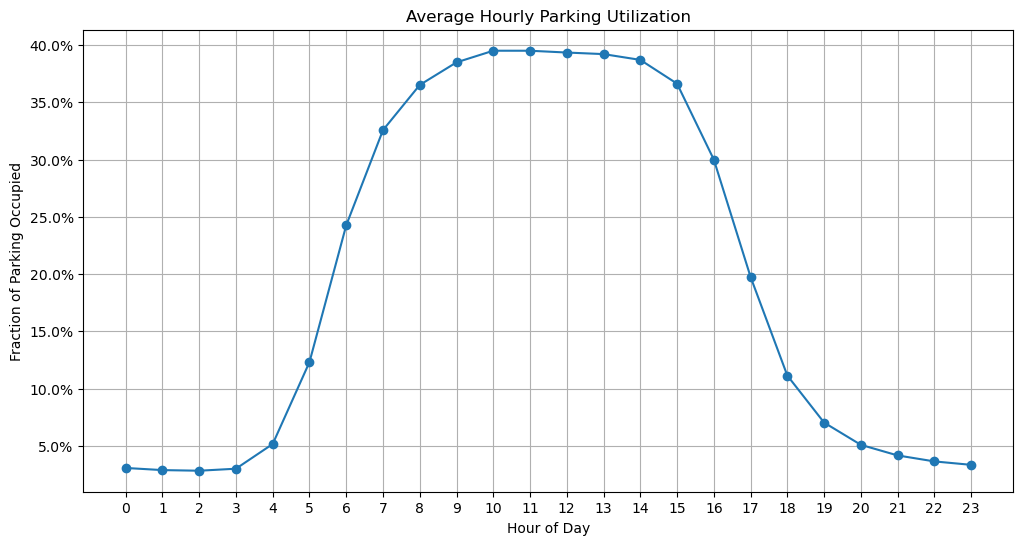

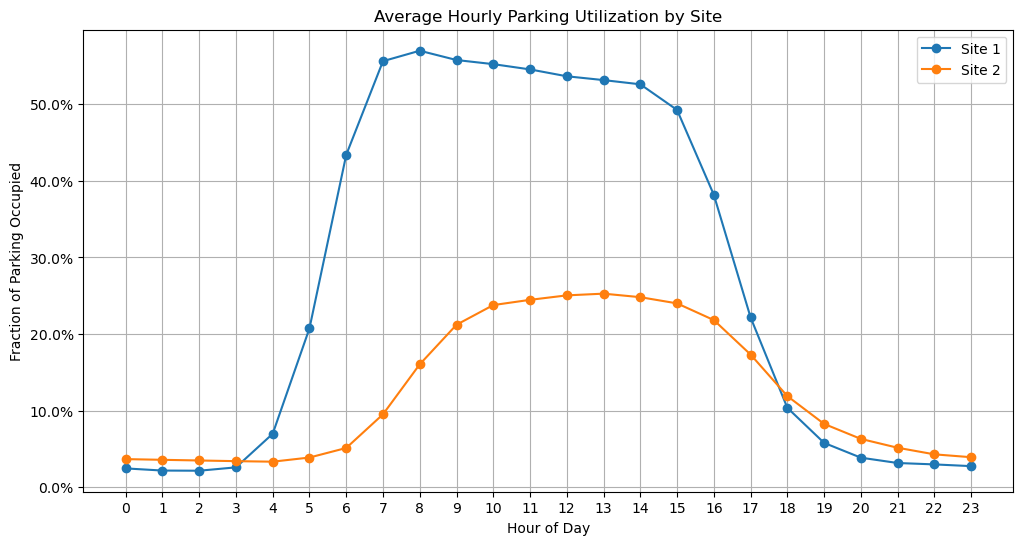

In [6]:
stations_per_site = df.groupby('siteID')['spaceID'].nunique()

df_occ = df[['siteID', 'spaceID', 'connectionTime', 'disconnectTime']].copy()

df_occ['start_hour'] = df_occ['connectionTime'].dt.floor('h')
df_occ['end_hour']   = df_occ['disconnectTime'].dt.floor('h')

# each row, a list of hourly timestamps the session occupied
def generate_hour_range(row):
    # If end_hour is earlier than start_hour return empty
    if row['end_hour'] < row['start_hour']:
        return []
    return pd.date_range(start=row['start_hour'], end=row['end_hour'], freq='h')

df_occ['hours_active'] = df_occ.apply(generate_hour_range, axis=1)

# each hour on its own row
df_exploded = df_occ.explode('hours_active', ignore_index=True)

# drop empty rows
df_exploded.dropna(subset=['hours_active'], inplace=True)

df_exploded['date'] = df_exploded['hours_active'].dt.date
df_exploded['hour'] = df_exploded['hours_active'].dt.hour

# Group by site, date, hour; count unique stations occupied
hourly_occ = (
    df_exploded
    .groupby(['siteID', 'date', 'hour'])['spaceID']
    .nunique()
    .reset_index(name='stations_occupied')
)

# Calculate utilization percentage
hourly_occ['utilization'] = hourly_occ.apply(
    lambda x: x['stations_occupied'] / stations_per_site[x['siteID']],
    axis=1
)

# Group by siteID, hour and compute the mean (averaged utilization across the days)
avg_hourly_utilization = (
    hourly_occ
    .groupby(['siteID', 'hour'], as_index=False)['utilization']
    .mean()
)

plt.figure(figsize=(12, 6))

# Group across all sites by 'hour' and take the mean utilization
overall_avg = avg_hourly_utilization.groupby('hour')['utilization'].mean()

plt.plot(overall_avg.index, overall_avg.values, marker='o')
plt.title('Average Hourly Parking Utilization')
plt.xlabel('Hour of Day')
plt.ylabel('Fraction of Parking Occupied')
# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()


plt.figure(figsize=(12, 6))

for site in [1, 2]:
    site_data = avg_hourly_utilization[avg_hourly_utilization['siteID'] == site]
    plt.plot(site_data['hour'], site_data['utilization'], 
             label=f'Site {site}', marker='o')

plt.title('Average Hourly Parking Utilization by Site')
plt.xlabel('Hour of Day')
plt.ylabel('Fraction of Parking Occupied')
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))
# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
plt.show()



## Parking Turnover Rate

### Definition
Number of charging sessions completed per station per hour

### Business Value
* Indicates efficiency of station usage
* Helps identify potential misuse (overstaying)

### Target
0.5-1.0 sessions per station per hour (site-dependent)

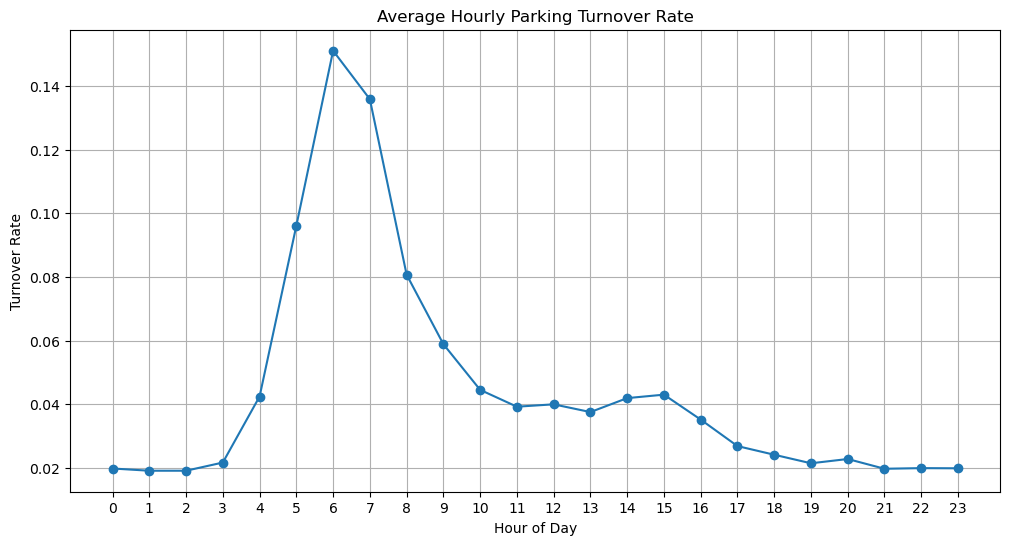

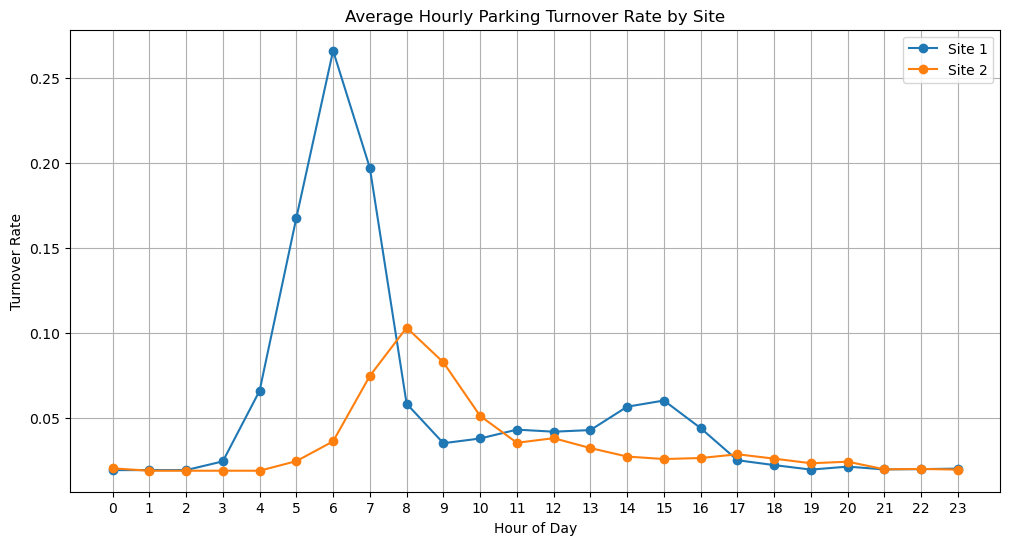

In [8]:
df_turnover = pd.DataFrame({
    'siteID': df['siteID'],
    'spaceID': df['spaceID'],
    'connectionTime': df['connectionTime']
})

df_turnover['date'] = df_turnover['connectionTime'].dt.date
df_turnover['hour'] = df_turnover['connectionTime'].dt.hour

stations_per_site = df.groupby('siteID')['spaceID'].nunique()


hourly_sessions = (
    df_turnover
    .groupby(['siteID', 'date', 'hour'])['spaceID']
    .count()
    .reset_index(name='num_sessions_started')
)

hourly_sessions['turnover_rate'] = hourly_sessions.apply(
    lambda x: x['num_sessions_started'] / stations_per_site[x['siteID']],
    axis=1
)

avg_hourly_turnover = (
    hourly_sessions
    .groupby(['siteID', 'hour'], as_index=False)['turnover_rate']
    .mean()
)


plt.figure(figsize=(12, 6))

overall_avg = avg_hourly_turnover.groupby('hour')['turnover_rate'].mean()
plt.plot(overall_avg.index, overall_avg.values, marker='o')

plt.title('Average Hourly Parking Turnover Rate')
plt.xlabel('Hour of Day')
plt.ylabel('Turnover Rate')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()


plt.figure(figsize=(12, 6))

for site in [1, 2]:
    site_data = avg_hourly_turnover[avg_hourly_turnover['siteID'] == site]
    plt.plot(
        site_data['hour'],
        site_data['turnover_rate'],
        marker='o',
        label=f'Site {site}'
    )

plt.title('Average Hourly Parking Turnover Rate by Site')
plt.xlabel('Hour of Day')
plt.ylabel('Turnover Rate')
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()



## Current Power Demand

### Definition
Total power currently being drawn by all active charging sessions

### Business Value
* Grid load management
* Peak demand monitoring
* Energy cost optimization
* Indicates how the site’s energy demand fluctuates throughout the day.
* Helps with power grid management, contract negotiations with utility providers, and anticipating peak-demand charges (commonly referenced in industry best practices for load management).
* Provides a direct measure of revenue potential if pricing is based on energy delivered.

### Target
Below site's maximum power capacity (<80% of total capacity)

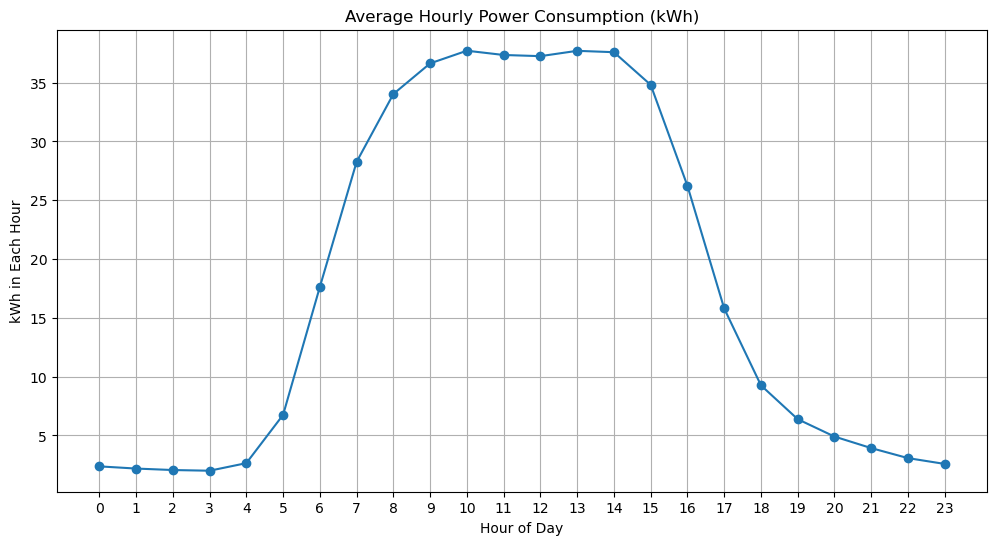

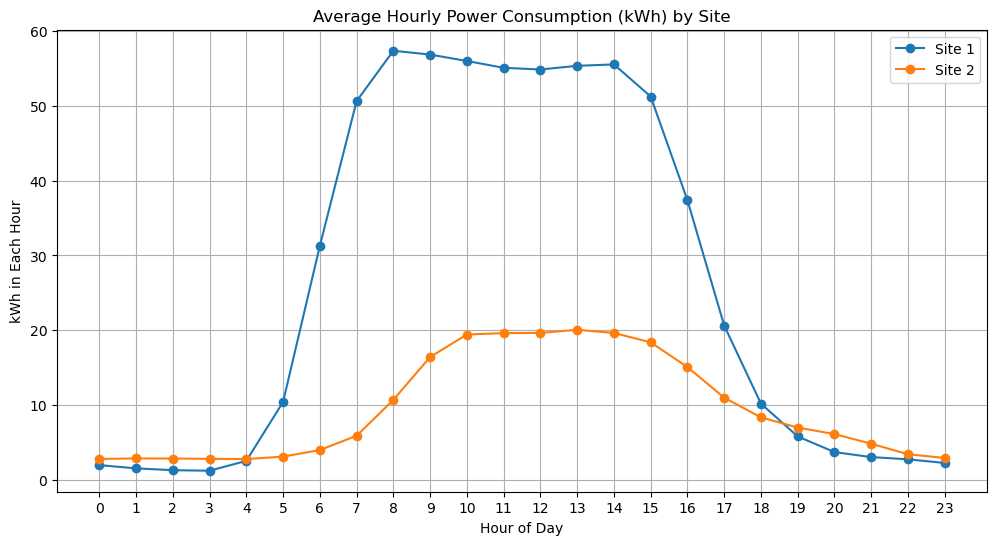

In [10]:
df_kwh = df[['siteID', 'spaceID', 'connectionTime', 'disconnectTime', 'kWhDelivered']].copy()

df_kwh['start_hour'] = df_kwh['connectionTime'].dt.floor('h')
df_kwh['end_hour'] = df_kwh['disconnectTime'].dt.floor('h')

def create_hourly_range(row):
    if row['end_hour'] < row['start_hour']:
        return []
    return pd.date_range(start=row['start_hour'], end=row['end_hour'], freq='h')

df_kwh['hourly_list'] = df_kwh.apply(create_hourly_range, axis=1)

df_exploded = df_kwh.explode('hourly_list', ignore_index=True)
df_exploded.dropna(subset=['hourly_list'], inplace=True)

df_exploded['hour_start'] = df_exploded['hourly_list']
df_exploded['hour_end'] = df_exploded['hourly_list'] + pd.Timedelta(hours=1)

def calc_overlap(row):
    overlap_start = max(row['connectionTime'], row['hour_start'])
    overlap_end = min(row['disconnectTime'], row['hour_end'])
    overlap = (overlap_end - overlap_start).total_seconds()
    # If negative or zero, no real overlap
    return max(overlap, 0)

# a session can partially overlap within an hour. 
# if a session spanned 2.0 hours total, and 0.5 hour of that was in the current hour block, 
# we get 0.5/2.0 = 25% of the total kWh assigned to this hour.

df_exploded['overlap_seconds'] = df_exploded.apply(calc_overlap, axis=1)
df_exploded['overlap_hours']   = df_exploded['overlap_seconds'] / 3600.0

# Total session hours
df_exploded['total_session_hours'] = (
    df_exploded['disconnectTime'] - df_exploded['connectionTime']
).dt.total_seconds() / 3600

# Avoid division-by-zero; if total_session_hours=0, set partial kWh=0
df_exploded['partial_kWh'] = np.where(
    df_exploded['total_session_hours'] > 0,
    df_exploded['kWhDelivered'] * (df_exploded['overlap_hours'] / df_exploded['total_session_hours']),
    0
)

df_exploded['date'] = df_exploded['hourly_list'].dt.date
df_exploded['hour'] = df_exploded['hourly_list'].dt.hour

hourly_kwh = (
    df_exploded
    .groupby(['siteID', 'date', 'hour'])['partial_kWh']
    .sum()
    .reset_index(name='total_kWh')
)

# average kWh by (siteID, hour)
avg_hourly_kwh = (
    hourly_kwh
    .groupby(['siteID', 'hour'], as_index=False)['total_kWh']
    .mean()
)

# overall average across all sites
overall_avg_kwh = (
    avg_hourly_kwh
    .groupby('hour', as_index=False)['total_kWh']
    .mean()
)

plt.figure(figsize=(12, 6))
plt.plot(overall_avg_kwh['hour'], overall_avg_kwh['total_kWh'], marker='o')
plt.title('Average Hourly Power Consumption (kWh)')
plt.xlabel('Hour of Day')
plt.ylabel('kWh in Each Hour')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()


plt.figure(figsize=(12, 6))
for site in [1, 2]:
    site_data = avg_hourly_kwh[avg_hourly_kwh['siteID'] == site]
    plt.plot(
        site_data['hour'], 
        site_data['total_kWh'], 
        label=f'Site {site}', 
        marker='o'
    )
plt.title('Average Hourly Power Consumption (kWh) by Site')
plt.xlabel('Hour of Day')
plt.ylabel('kWh in Each Hour')
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()



## Estimated Wait Time

### Definition
Expected time until next available charging station

### Business Value
* Customer experience management
* Queue management
* Real-time user communication

### Target
< 15 minutes during peak hours, 0 minutes during off-peak

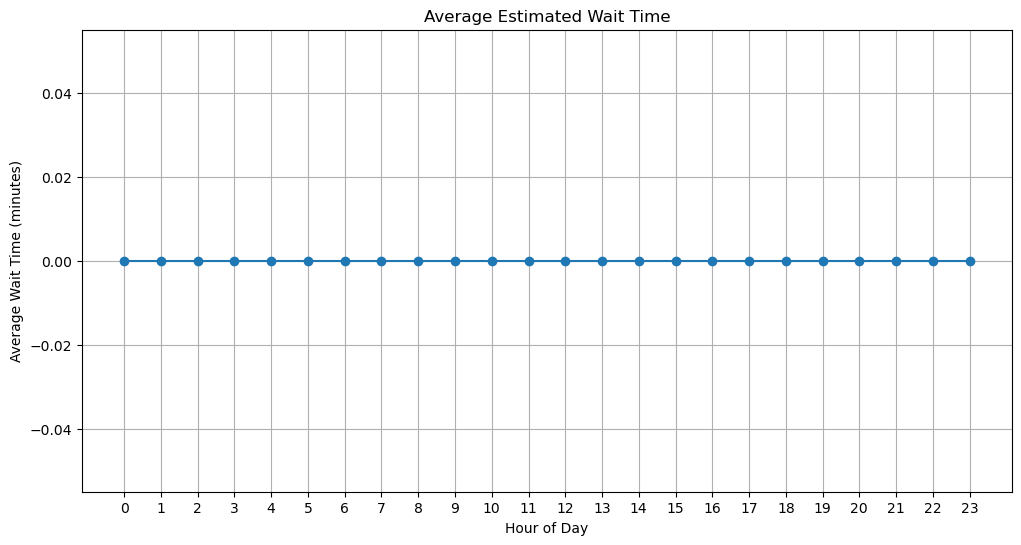

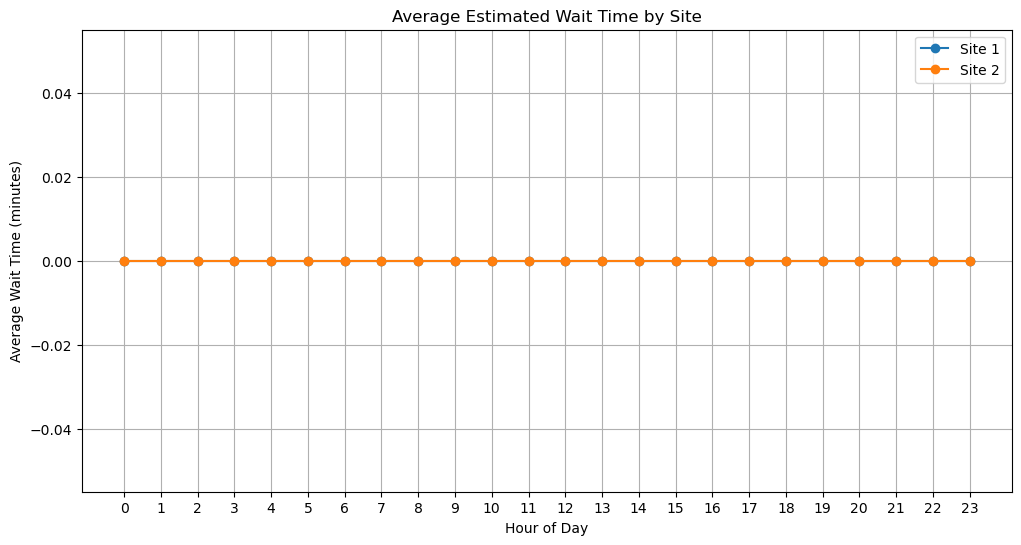

In [11]:
wait_df = pd.DataFrame({
    'siteID': df['siteID'],
    'date': df['connectionTime'].dt.date,
    'hour': df['connectionTime'].dt.hour,
    'connectionTime': df['connectionTime'],
    'doneChargingTime': df['doneChargingTime']
})

def calculate_wait_time(group, total_stations):
    if len(group) < total_stations:
        return 0  # No wait if stations available
    
    sorted_sessions = group.sort_values('doneChargingTime')
    next_available = sorted_sessions.iloc[total_stations-1]['doneChargingTime']
    wait_times = (next_available - group['connectionTime']).dt.total_seconds() / 60
    return wait_times.mean()

hourly_wait_times = []

for site in wait_df['siteID'].unique():
    site_data = wait_df[wait_df['siteID'] == site]
    total_stations = stations_per_site[site]
    
    for date in site_data['date'].unique():
        for hour in range(24):
            # Get sessions active in this hour
            hour_data = site_data[
                (site_data['date'] == date) & 
                (site_data['hour'] == hour)
            ]
            
            if not hour_data.empty:
                wait_time = calculate_wait_time(hour_data, total_stations)
                hourly_wait_times.append({
                    'siteID': site,
                    'date': date,
                    'hour': hour,
                    'wait_time_minutes': wait_time
                })

wait_times_df = pd.DataFrame(hourly_wait_times)

# Calculate average wait times by hour for each site
avg_hourly_wait = wait_times_df.groupby(['siteID', 'hour'])['wait_time_minutes'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(avg_hourly_wait.groupby('hour')['wait_time_minutes'].mean(), marker='o')
plt.title('Average Estimated Wait Time')
plt.xlabel('Hour of Day')
plt.ylabel('Average Wait Time (minutes)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

plt.figure(figsize=(12, 6))
for site in [1, 2]:
    site_data = avg_hourly_wait[avg_hourly_wait['siteID'] == site]
    plt.plot(site_data['hour'], site_data['wait_time_minutes'], 
             label=f'Site {site}', marker='o')

plt.title('Average Estimated Wait Time by Site')
plt.xlabel('Hour of Day')
plt.ylabel('Average Wait Time (minutes)')
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

## Average Session Duration per Hour

### Definition
Tracks how long, on average, drivers remain connected to the charging stations each hour.

### Business Value
* Gives insight into whether drivers are lingering after charging is done (potentially blocking stations).
* Reveals trends in how long sessions take at different times of day, which can inform pricing or time-limit policies.
* Helps forecast station availability and capacity planning (e.g., if sessions are longer during peak hours, you might need more stations or policies to encourage quicker turnover).

### Target


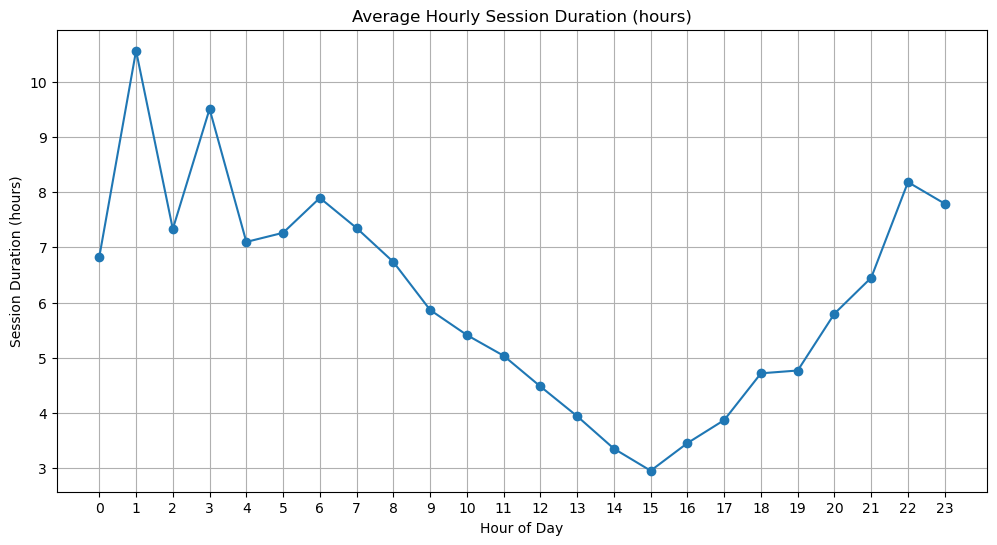

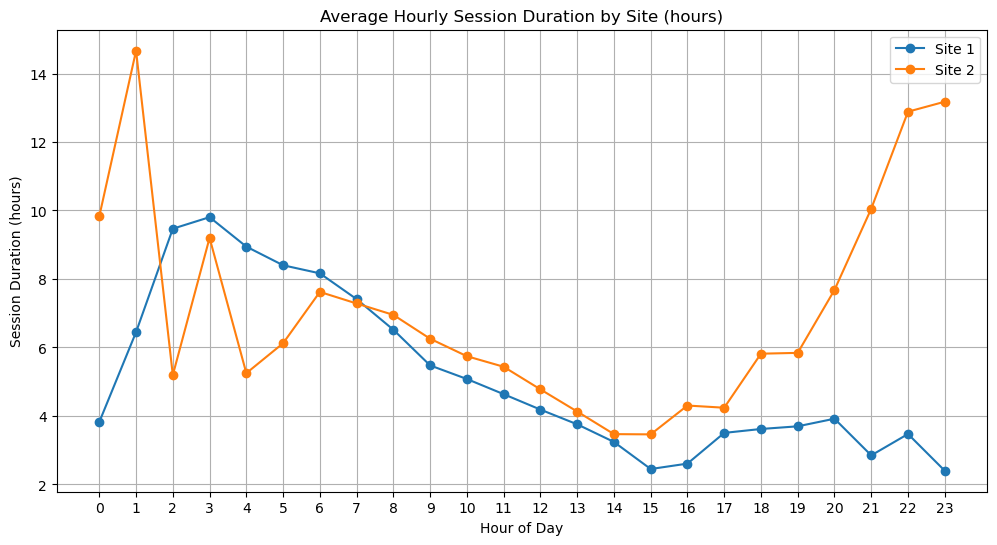

In [14]:
df_sessions = pd.DataFrame({
    'siteID': df['siteID'],
    'connectionTime': df['connectionTime'],
    'disconnectTime': df['disconnectTime']
})

df_sessions['date'] = df_sessions['connectionTime'].dt.date
df_sessions['hour'] = df_sessions['connectionTime'].dt.hour

df_sessions['sessionDuration'] = df['parkDuration'] / pd.Timedelta(hours=1)

# Group by site, date, hour and compute mean session duration
hourly_duration = df_sessions.groupby(['siteID', 'date', 'hour'])['sessionDuration'].mean().reset_index()

# Calculate average session duration per hour across days for each site
avg_hourly_duration = hourly_duration.groupby(['siteID', 'hour'])['sessionDuration'].mean().reset_index()


plt.figure(figsize=(12, 6))
overall_avg = avg_hourly_duration.groupby('hour')['sessionDuration'].mean()
plt.plot(overall_avg.index, overall_avg.values, marker='o')
plt.title('Average Hourly Session Duration (hours)')
plt.xlabel('Hour of Day')
plt.ylabel('Session Duration (hours)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()


plt.figure(figsize=(12, 6))
for site in [1, 2]:
    site_data = avg_hourly_duration[avg_hourly_duration['siteID'] == site]
    plt.plot(site_data['hour'], site_data['sessionDuration'],
             label=f'Site {site}', marker='o')

plt.title('Average Hourly Session Duration by Site (hours)')
plt.xlabel('Hour of Day')
plt.ylabel('Session Duration (hours)')
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()



---